# E8
---

## Environment Setting
---

In [1]:
import os
os.environ['CUDA_VISIBLE_DEVICES'] = '0'

import math
import numpy as np
import tensorflow as tf

import keras
import h5py
from pathlib import Path

import matplotlib.pyplot as plt
import cv2
import math
from tqdm import tqdm

%env SM_FRAMEWORK=tf.keras
import segmentation_models as sm
import albumentations as A

import seaborn
seaborn.set(style='white')
seaborn.set_context('paper')

env: SM_FRAMEWORK=tf.keras
Segmentation Models: using `tf.keras` framework.


In [2]:
import tensorflow as tf
def init_gpu():
    gpus = tf.config.experimental.list_physical_devices('GPU')
    if gpus:
        try:
            # Currently, memory growth needs to be the same across GPUs
            for gpu in gpus:
                tf.config.experimental.set_memory_growth(gpu, True)
            logical_gpus = tf.config.experimental.list_logical_devices('GPU')

            print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs\n\n")
        except RuntimeError as e:
            # Memory growth must be set before GPUs have been initialized
            print(e, "\n\n")

init_gpu()

1 Physical GPUs, 1 Logical GPUs




In [3]:
FILE_PATH = '/workspace/Model/data/LV1_PNG_DATASET_B.h5'
BASE_TARIN_DIR = "/train"
TRAIN_IMG_PATH = f'{Path(BASE_TARIN_DIR)}/img'
TRAIN_LABEL_PATH = f'{Path(BASE_TARIN_DIR)}/label'
TRAIN_SPLIT_DIR = f'{Path(BASE_TARIN_DIR)}/split'  
TRAIN_SPLIT_IMG_PATH = f'{Path(BASE_TARIN_DIR)}/split/img'           
TRAIN_SPLIT_LABEL_PATH = f'{Path(BASE_TARIN_DIR)}/split/label'                                                                                                                         

BASE_VAL_DIR = "/val"
VAL_IMG_PATH = f'{Path(BASE_VAL_DIR)}/img'
VAL_LABEL_PATH = f'{Path(BASE_VAL_DIR)}/label'
VAL_SPLIT_DIR = f'{Path(BASE_VAL_DIR)}/split'  
VAL_SPLIT_IMG_PATH = f'{Path(BASE_VAL_DIR)}/split/img'           
VAL_SPLIT_LABEL_PATH = f'{Path(BASE_VAL_DIR)}/split/label'  

BASE_TEST_DIR = "/test"
TEST_IMG_PATH = f'{Path(BASE_TEST_DIR)}/img'
TEST_LABEL_PATH = f'{Path(BASE_TEST_DIR)}/label'
TEST_SPLIT_DIR = f'{Path(BASE_TEST_DIR)}/split'  
TEST_SPLIT_IMG_PATH = f'{Path(BASE_TEST_DIR)}/split/img'           
TEST_SPLIT_LABEL_PATH = f'{Path(BASE_TEST_DIR)}/split/label'  

IMAGE_SIZE = 1024
IMG_CHANNELS = 3

COLOR_MAP = [
    (165, 42, 42),
    (0, 192, 0),
    (255,255,255)
]

### dataset 확인

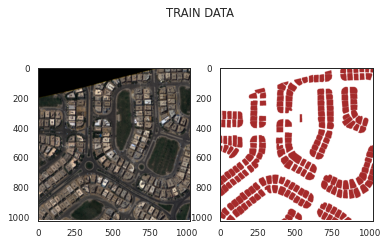

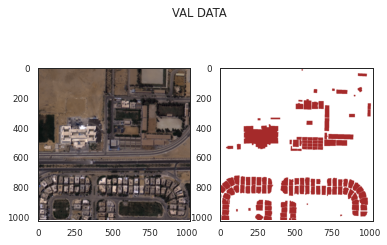

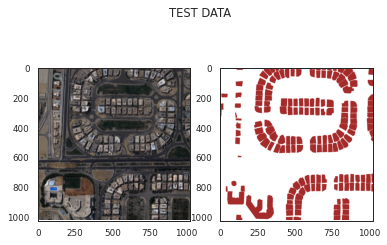

In [4]:
import matplotlib.pyplot as plt
i = 0

with h5py.File(FILE_PATH, 'r') as hdf5_file:
    plt.suptitle('TRAIN DATA')
    plt.subplot(121)
    plt.imshow(hdf5_file[TRAIN_IMG_PATH][i])
    plt.subplot(122)
    plt.imshow(hdf5_file[TRAIN_LABEL_PATH][i])
    plt.show()
    
    plt.suptitle('VAL DATA')
    plt.subplot(121)
    plt.imshow(hdf5_file[VAL_IMG_PATH][i])
    plt.subplot(122)
    plt.imshow(hdf5_file[VAL_LABEL_PATH][i])
    plt.show()
    
    plt.suptitle('TEST DATA')
    plt.subplot(121)
    plt.imshow(hdf5_file[TEST_IMG_PATH][i])
    plt.subplot(122)
    plt.imshow(hdf5_file[TEST_LABEL_PATH][i])
    plt.show()

## Split and Save image
---

### 함수정의

In [102]:
def get_slice_pos(split_cnt, STRIDE_SIZE, INPUT_SIZE):
    pts = []
    n = math.sqrt(split_cnt)
    for slice_pos in range(split_cnt):
        pos_i = int(math.floor(slice_pos / n))
        pos_j = int(slice_pos % int(n))
        x = STRIDE_SIZE * pos_i
        y = STRIDE_SIZE * pos_j
        pts.append((x, x+INPUT_SIZE, y, y+INPUT_SIZE))
    return pts

In [6]:
def random_crop(img, mask, crop_num, height=256, width=256): 
    cropper = A.RandomCrop(height, width)
    croped = [cropper(image=img, mask=mask) for _ in range(crop_num)]
    return [sub['image'] for sub in croped], [sub['mask'] for sub in croped]

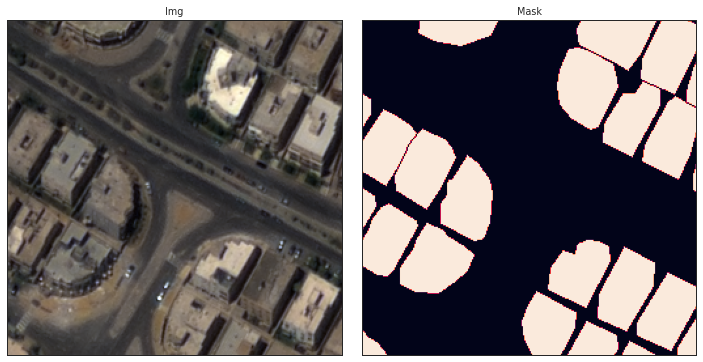

In [30]:
# with h5py.File(FILE_PATH, "a") as f:
#     img = f[TRAIN_IMG_PATH][0]
#     mask = (f[TRAIN_LABEL_PATH][0] == COLOR_MAP[0])
#     mask = (mask[:,:,0] +  mask[:,:,1] +  mask[:,:,2]).astype(np.float32)
#     sub_imgs, sub_labels = random_crop(img, mask, 1)
#     visualize(img=sub_imgs[0], mask=sub_labels[0])

In [7]:
def split_png(img, pts):
    if len(img.shape) == 3:
        sub_imgs = [img[x0:x1, y0:y1, :] for x0, x1, y0, y1 in pts]
    elif len(img.shape) == 2:
        sub_imgs = [img[x0:x1, y0:y1] for x0, x1, y0, y1 in pts]
    return sub_imgs

In [8]:
def save_png_imgs_labels(dataset, i, imgs, labels):
    for img, label in zip(imgs, labels):
        dataset['img'][i, ...] = img
        dataset['label'][i, ...] = label
        i += 1
    return i

### Split

In [9]:
CROP_NUM = 15

In [10]:
with h5py.File(FILE_PATH, "a") as f:
    train_size = f[TRAIN_IMG_PATH].shape[0] * CROP_NUM
    if 'split' in f[BASE_TARIN_DIR].keys(): del f[TRAIN_SPLIT_DIR]
    f[BASE_TARIN_DIR].create_group('split')
    f[BASE_TARIN_DIR]['split'].create_dataset('img', (train_size, 256, 256, 3), np.uint8)
    f[BASE_TARIN_DIR]['split'].create_dataset('label', (train_size, 256, 256), np.float32)

    val_size = f[VAL_IMG_PATH].shape[0] * CROP_NUM
    if 'split' in f[BASE_VAL_DIR].keys(): del f[VAL_SPLIT_DIR]
    f[BASE_VAL_DIR].create_group('split')
    f[BASE_VAL_DIR]['split'].create_dataset('img', (val_size, 256, 256, 3), np.uint8)
    f[BASE_VAL_DIR]['split'].create_dataset('label', (val_size, 256, 256), np.float32)

    test_size = f[TEST_IMG_PATH].shape[0] * CROP_NUM
    if 'split' in f[BASE_TEST_DIR].keys(): del f[TEST_SPLIT_DIR]
    f[BASE_TEST_DIR].create_group('split')
    f[BASE_TEST_DIR]['split'].create_dataset('img', (test_size, 256, 256, 3), np.uint8)
    f[BASE_TEST_DIR]['split'].create_dataset('label', (test_size, 256, 256), np.float32)

    sub_idx = 0
    for i in tqdm(range(f[TRAIN_IMG_PATH].shape[0])):
        img = f[TRAIN_IMG_PATH][i]
        mask = (f[TRAIN_LABEL_PATH][i] == COLOR_MAP[0])
        mask = (mask[:,:,0] +  mask[:,:,1] +  mask[:,:,2]).astype(np.float32)
        sub_imgs, sub_labels = random_crop(img, mask, CROP_NUM)
        
        sub_idx = save_png_imgs_labels(f[TRAIN_SPLIT_DIR], sub_idx, sub_imgs, sub_labels)

    sub_idx = 0
    for i in tqdm(range(f[VAL_IMG_PATH].shape[0])):
        img = f[VAL_IMG_PATH][i]
        mask = (f[VAL_LABEL_PATH][i] == COLOR_MAP[0])
        mask = (mask[:,:,0] +  mask[:,:,1] +  mask[:,:,2]).astype(np.float32)
        sub_imgs, sub_labels = random_crop(img, mask, CROP_NUM)

        sub_idx = save_png_imgs_labels(f[VAL_SPLIT_DIR], sub_idx, sub_imgs, sub_labels)
        
    sub_idx = 0
    for i in tqdm(range(f[TEST_IMG_PATH].shape[0])):
        img = f[TEST_IMG_PATH][i]
        mask = (f[TEST_LABEL_PATH][i] == COLOR_MAP[0])
        mask = (mask[:,:,0] +  mask[:,:,1] +  mask[:,:,2]).astype(np.float32)
        sub_imgs, sub_labels = random_crop(img, mask, CROP_NUM)

        sub_idx = save_png_imgs_labels(f[TEST_SPLIT_DIR], sub_idx, sub_imgs, sub_labels)

100%|██████████| 159/159 [00:04<00:00, 34.21it/s]


### Sample

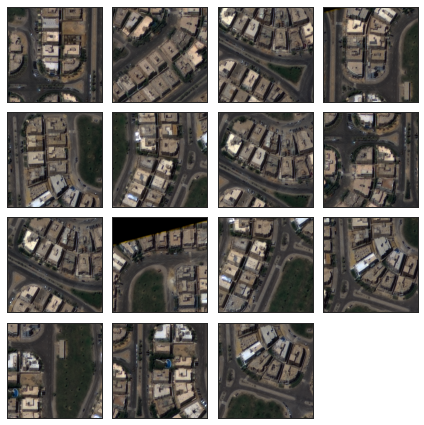

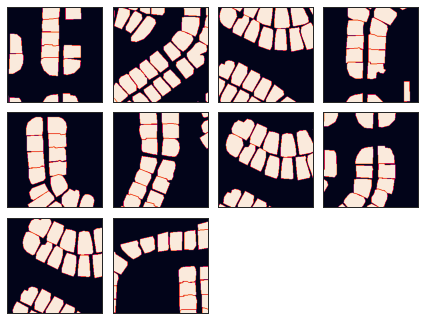

In [12]:
with h5py.File(FILE_PATH, "a") as f:
    idx = 0
    imgs = f[TRAIN_SPLIT_IMG_PATH][idx*15:idx*15+15]
    plt.figure(figsize=(6, 6))
    for i, sub_img in enumerate(imgs):
        if i == 15: break
        plt.subplot(4, 4, i+1)
        ax = plt.gca()
        ax.axes.xaxis.set_visible(False)
        ax.axes.yaxis.set_visible(False)
        plt.imshow(sub_img)
            
    plt.tight_layout()
    plt.show()
    
    masks = f[TRAIN_SPLIT_LABEL_PATH][idx*10:idx*10+10]
    plt.figure(figsize=(6, 6))
    for i, sub_img in enumerate(masks):
        if i == 15: break
        plt.subplot(4, 4, i+1)
        ax = plt.gca()
        ax.axes.xaxis.set_visible(False)
        ax.axes.yaxis.set_visible(False)
        plt.imshow(sub_img)
            
    plt.tight_layout()
    plt.show()

## Dataloader and utility functions
---

In [13]:
def visualize(**images):
    """PLot images in one row."""
    n = len(images)
    fig, axs = plt.subplots(1, n, figsize=(10, 5))
    
    for i, (name, image) in enumerate(images.items()):
        axs[i].set_xticks([])
        axs[i].set_yticks([])
        axs[i].set_title(' '.join(name.split('_')).title())
        axs[i].imshow(image)
        
    plt.tight_layout()
    plt.show()

In [14]:
# helper function for data visualization    
def denormalize(x):
    """Scale image to range 0..1 for correct plot"""
    x_max = np.percentile(x, 98)
    x_min = np.percentile(x, 2)    
    x = (x - x_min) / (x_max - x_min)
    x = x.clip(0, 1)
    return x

In [15]:
def round_clip_0_1(x, **kwargs):
    return x.round().clip(0, 1)

def get_training_augmentation():
    train_transform = [
        A.RandomRotate90(p=0.5),
        A.RandomRotate90(p=0.5),
        A.RandomRotate90(p=0.5),
        A.Lambda(mask=round_clip_0_1)
    ]
    return A.Compose(train_transform)


def get_validation_augmentation():
    """Add paddings to make image shape divisible by 32"""
    test_transform = [
        A.Lambda(mask=round_clip_0_1)
    ]
    return A.Compose(test_transform)

def get_preprocessing(preprocessing_fn):
    """Construct preprocessing transform
    
    Args:
        preprocessing_fn (callbale): data normalization function 
            (can be specific for each pretrained neural network)
    Return:
        transform: albumentations.Compose
    
    """
    _transform = [
        A.CLAHE(clip_limit=2.0, tile_grid_size=(16, 16), p=1),
        A.Lambda(image=preprocessing_fn),
    ]
    return A.Compose(_transform)

In [16]:
class SatelliteGenerator(tf.keras.utils.Sequence):
    '''
    ref: https://github.com/AIFFEL-FREESIA/Model/blob/master/Unet_building_256_2.ipynb
    SatelliteGenerator는 tf.keras.utils.Sequence를 상속받습니다.
    '''
    def __init__(self, 
                 filepath,
                 x_path,
                 y_path,
                 batch_size=8,
                 augmentation=None, 
                 preprocessing=None,
                 is_train=True):
        
        self.filepath = filepath
        self.x_path = x_path
        self.y_path = y_path
        
        self.augmentation = augmentation
        self.preprocessing = preprocessing

        self.size = 0
        with h5py.File(self.filepath, 'r') as f:
            self.size = f[x_path].shape[0]
            
        self.batch_size = batch_size
        self.is_train = is_train
    
    def __len__(self):
        return math.ceil(self.size / self.batch_size)

    def __getitem__(self, index):
        with h5py.File(self.filepath, 'r') as f:
            images = f[self.x_path][index*self.batch_size : (index + 1)*self.batch_size]
            masks = f[self.y_path][index*self.batch_size : (index + 1)*self.batch_size]
            res = [(img, mask) for img, mask in zip(images, masks)]

            if self.augmentation:
                res = [self.augmentation(image=img, mask=mask) for img, mask in res]
                res = [(r['image'], r['mask']) for r in res]
            if self.preprocessing:
                res = [self.preprocessing(image=img, mask=mask) for img, mask in res]
                res = [(r['image'], r['mask']) for r in res]
            
            images = np.array([img for img, _ in res ])
            masks = np.array([mask for _, mask in res ])
            
            return images, masks

    def on_epoch_end(self):
        # 한 epoch가 끝나면 실행되는 함수입니다. 학습중인 경우에 순서를 random shuffle하도록 적용한 것을 볼 수 있습니다.
        self.indexes = np.arange(self.size)
        if self.is_train == True :
            np.random.shuffle(self.indexes)
        
        return self.indexes

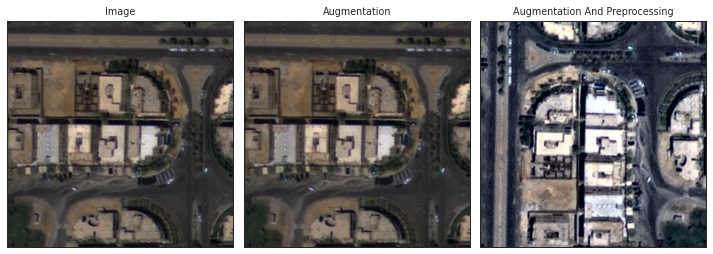

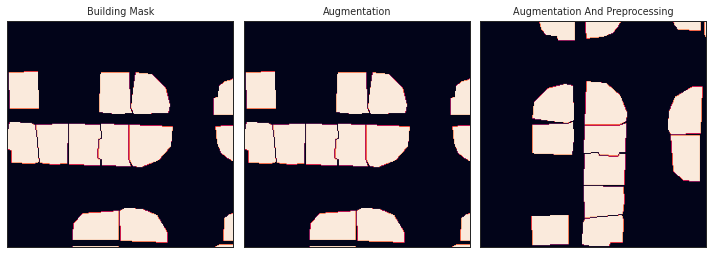

In [18]:
# Lets look at augmented data we have
dataset = SatelliteGenerator(
    FILE_PATH,
    TRAIN_SPLIT_IMG_PATH,
    TRAIN_SPLIT_LABEL_PATH, 
    augmentation=get_training_augmentation()
)

dataset_aug = SatelliteGenerator(
    FILE_PATH,
    TRAIN_SPLIT_IMG_PATH,
    TRAIN_SPLIT_LABEL_PATH, 
    augmentation=get_training_augmentation())

preprocess_input = sm.get_preprocessing('efficientnetb3')
dataset_aug_pre = SatelliteGenerator(
    FILE_PATH,
    TRAIN_SPLIT_IMG_PATH,
    TRAIN_SPLIT_LABEL_PATH,
    augmentation=get_training_augmentation(),
    preprocessing=get_preprocessing(preprocess_input)
)

idx = 0
image, mask = dataset[idx] # get some sample
image_aug, mask_aug = dataset_aug[idx]
image_aug_pre, mask_aug_pre = dataset_aug_pre[idx]


visualize(
    image=image[0], 
    augmentation=image_aug[0],
    augmentation_and_preprocessing=denormalize(image_aug_pre[0])
)

visualize(
    building_mask=mask[0],
    augmentation=mask_aug[0],
    augmentation_and_preprocessing=mask_aug_pre[0]
)

# Train Model

### functions

In [19]:
def get_datagenerator(BATCH_SIZE=8, BACKBONE='efficientnetb3'):
    # Dataset for train images
    preprocess_input = sm.get_preprocessing(BACKBONE)
    train_datagenerator = SatelliteGenerator(
        FILE_PATH,
        TRAIN_SPLIT_IMG_PATH,
        TRAIN_SPLIT_LABEL_PATH,
        batch_size=BATCH_SIZE,
        augmentation=get_training_augmentation(),
        preprocessing=get_preprocessing(preprocess_input),
        is_train=True
    )

    # Dataset for validation image
    valid_datagenerator = SatelliteGenerator(
        FILE_PATH,
        VAL_SPLIT_IMG_PATH, 
        VAL_SPLIT_LABEL_PATH, 
        batch_size=BATCH_SIZE,
        augmentation=get_validation_augmentation(),
        preprocessing=get_preprocessing(preprocess_input),
        is_train=False
    )

    return train_datagenerator, valid_datagenerator

In [20]:
import time
import datetime
def logging_time(original_fn):
    def wrapper_fn(*args, **kwargs):
        start_time = time.time()
        
        result = original_fn(*args, **kwargs)
        
        sec = time.time()-start_time
        times = str(datetime.timedelta(seconds=sec)).split(".")
        times = times[0]
        print(f'WorkingTime : {times}')
        return result
    return wrapper_fn

In [21]:
def get_cosine_lr(initial_learning_rate, t_period, lr_min=0.):
    return tf.keras.experimental.CosineDecay(
        initial_learning_rate=initial_learning_rate,
        decay_steps=t_period, alpha=lr_min / initial_learning_rate)

In [45]:
def get_model(model_name, optim, train, valid, MODEL_PATH, patience=5):
    BACKBONE = 'efficientnetb3'
    CLASSES = ['building']

    # define network parameters
    n_classes = 1 if len(CLASSES) == 1 else (len(CLASSES) + 1)  # case for binary and multiclass segmentation
    activation = 'sigmoid' if n_classes == 1 else 'softmax'

    #create model
    tf.random.set_seed(2021)
    model = sm.Unet(BACKBONE, classes=n_classes, activation=activation, encoder_weights='imagenet')

    # Segmentation models losses can be combined together by '+' and scaled by integer or float factor
    dice_loss = sm.losses.DiceLoss()
    focal_loss = sm.losses.BinaryFocalLoss() if n_classes == 1 else sm.losses.CategoricalFocalLoss()
    total_loss = dice_loss + (1 * focal_loss)
    metrics = [sm.metrics.IOUScore(threshold=0.5), sm.metrics.FScore(threshold=0.5)]

    # compile keras model with defined optimozer, loss and metrics
    model.compile(optim, total_loss, metrics)
    
    log_dir = f"./logs/fit/{model_name}"
    tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)
    callbacks = [
        keras.callbacks.ModelCheckpoint(MODEL_PATH, save_weights_only=True, save_best_only=True, mode='min', monitor='val_loss'),
        keras.callbacks.ReduceLROnPlateau(monitor='val_loss', 
                                          factor=0.1, 
                                          patience=5, 
                                          verbose=1, 
                                          mode='min'),
        tensorboard_callback,
        keras.callbacks.EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=patience)
    ]
    
    return model, callbacks

In [23]:
def show_history_plot(history):
    fig, axes = plt.subplots(1, 3, figsize=(15, 5))
    keys = [('loss', 'val_loss'), ('iou_score', 'val_iou_score'), ('f1-score', 'val_f1-score')]
    
    for (train, val), ax in zip(keys, axes):
        ax.plot(history[train])
        ax.plot(history[val])
        ax.set_title(f'Model {train}')
        ax.set_ylabel(train)
        ax.set_xlabel('Epoch')
        ax.legend(['Train', 'Validation'], loc='upper left')

    plt.tight_layout()
    plt.show()
# show_history_plot(new_history)

In [24]:
def inference(model, img, pts):
    preprocessing = A.Compose([
        A.CLAHE(clip_limit=2.0, tile_grid_size=(16, 16), p=1),
        A.Lambda(image=sm.get_preprocessing(BACKBONE)),
    ])

    sub_imgs = git(img, pts)
    sub_imgs = [preprocessing(image=img)['image'] for img in sub_imgs]
#     show_spiltd_img(sub_imgs, denor=True)

    sub_imgs = [np.expand_dims(img, axis=0) for img in sub_imgs]
    pre_imgs = [model.predict(img) for img in sub_imgs]
    pre_imgs = [pre[..., 0].squeeze() for pre in pre_imgs]
    pre_imgs = [pre.round().clip(0, 1) for pre in pre_imgs]
#     show_spiltd_img(pre_imgs)
    
    merged = np.zeros((1024, 1024))
    for i, (x0, x1, y0, y1) in enumerate(pts) : 
        sub = (merged[x0:x1, y0:y1] + pre_imgs[i])/2
        sub = np.where(sub - sub//1 > 0, sub+0.00001, sub)
        sub = np.round(sub)
        merged[x0:x1, y0:y1] = sub
    return merged

In [32]:
STRIDE_SIZE = 192
INPUT_SIZE = 256
SPLIT_CNT = 25

def show_inference(model):
    pts = get_slice_pos(SPLIT_CNT, STRIDE_SIZE, INPUT_SIZE)
    with h5py.File(FILE_PATH, "r") as f:
        for idx in range(5):
            img = f[TEST_IMG_PATH][idx]
            mask = (f[TEST_LABEL_PATH][idx] == COLOR_MAP[0])
            mask = (mask[:,:,0] +  mask[:,:,1] +  mask[:,:,2]).astype(np.float32)


            predicted = inference(model, img, pts)
            images = {'Image': img, 
                      'Ground Truth': mask,
                      'Prediction': predicted}

            visualize(
                image=img,
                ground_truth=mask,
                predicted=predicted
            )

### E8

In [26]:
lr = 1e-3
BATCH_SIZE = 32
EPOCHS = 100
SPLIT_CNT = 15
optim = keras.optimizers.Adam(learning_rate=lr)
train_datagenerator, valid_datagenerator = get_datagenerator(BATCH_SIZE=BATCH_SIZE)

In [28]:
model_8_1, callbacks = get_model('E8-1',
                                 optim,
                                  train_datagenerator, 
                                  valid_datagenerator,
                                  '/workspace/Model/trained_model/E8/E8_1.h5',
                                  patience=10)

44113920/44107200 [==============================] - 1s 0us/step


In [25]:
start_time = time.time()

history_8_1 = model_8_1.fit(
    train_datagenerator, 
    steps_per_epoch=len(train_datagenerator), 
    epochs=EPOCHS, 
    callbacks=callbacks, 
    validation_data=valid_datagenerator, 
    validation_steps=len(valid_datagenerator))

sec = time.time()-start_time
times = str(datetime.timedelta(seconds=sec)).split(".")
times = times[0]
print(f'WorkingTime : {times}')

Epoch 1/100
340/340 [==============================] - 423s 676ms/step - loss: 0.6399 - iou_score: 0.3662 - f1-score: 0.5106 - val_loss: 0.5981 - val_iou_score: 0.3785 - val_f1-score: 0.5409
Epoch 2/100
340/340 [==============================] - 151s 445ms/step - loss: 0.4403 - iou_score: 0.5417 - f1-score: 0.6923 - val_loss: 0.3972 - val_iou_score: 0.6001 - val_f1-score: 0.7437
Epoch 3/100
340/340 [==============================] - 151s 444ms/step - loss: 0.3797 - iou_score: 0.5871 - f1-score: 0.7311 - val_loss: 0.3570 - val_iou_score: 0.6332 - val_f1-score: 0.7702
Epoch 4/100
340/340 [==============================] - 152s 445ms/step - loss: 0.3325 - iou_score: 0.6261 - f1-score: 0.7639 - val_loss: 0.4046 - val_iou_score: 0.5302 - val_f1-score: 0.6836
Epoch 5/100
340/340 [==============================] - 152s 446ms/step - loss: 0.2920 - iou_score: 0.6677 - f1-score: 0.7968 - val_loss: 0.4068 - val_iou_score: 0.5493 - val_f1-score: 0.6945
Epoch 6/100
340/340 [========================

In [ ]:
show_history_plot(history_8_1.history)

#### evaluation

In [29]:
model_8_1.load_weights('/workspace/Model/trained_model/E8/E8_1.h5')

In [30]:
preprocess_input = sm.get_preprocessing('efficientnetb3')
test_datagenerator = SatelliteGenerator(
    FILE_PATH,
    TEST_SPLIT_IMG_PATH, 
    TEST_SPLIT_LABEL_PATH, 
    batch_size=BATCH_SIZE,
    augmentation=get_validation_augmentation(),
    preprocessing=get_preprocessing(preprocess_input),
    is_train=False
)
val_metrix = model_8_1.evaluate(valid_datagenerator)
test_metrix = model_8_1.evaluate(test_datagenerator)

75/75 [==============================] - 50s 671ms/step - loss: 0.2628 - iou_score: 0.7076 - f1-score: 0.8173


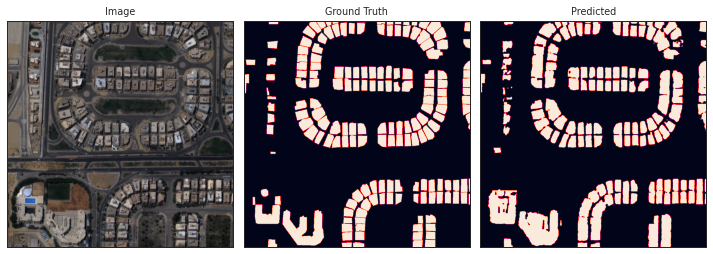

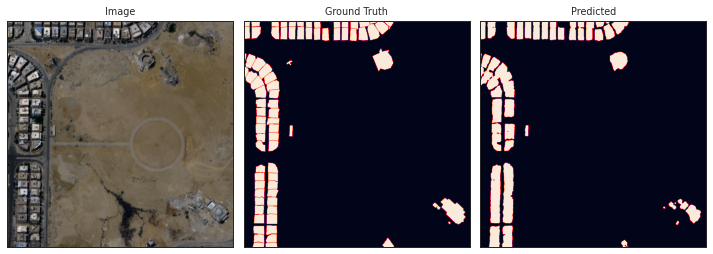

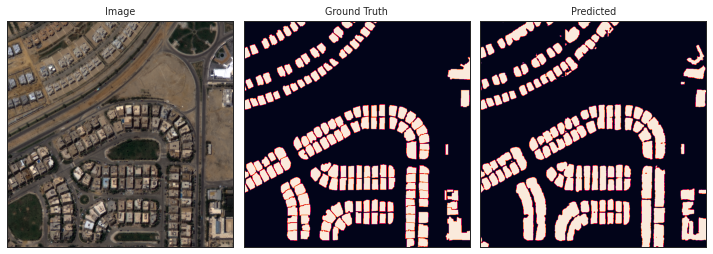

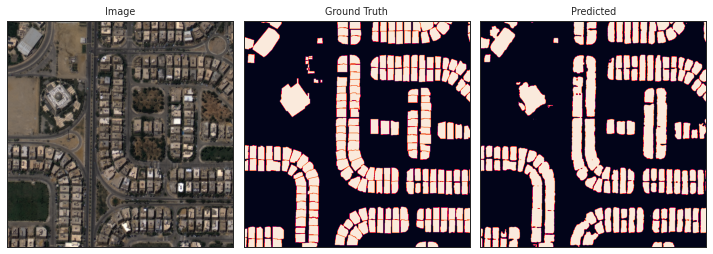

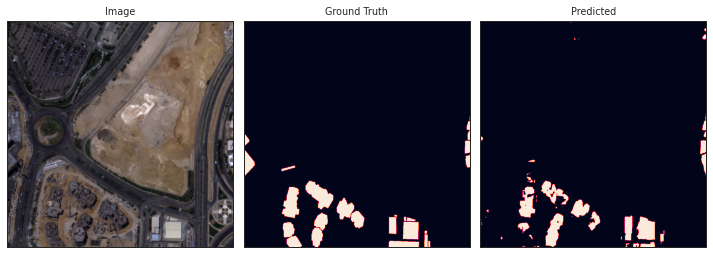

In [33]:
BACKBONE = 'efficientnetb3'
show_inference(model_8_1)

### E8-2

SPLIT_CNT = 15

In [35]:
lr = 1e-3
BATCH_SIZE = 32
EPOCHS=200
optim = keras.optimizers.Adam(learning_rate=lr)
train_datagenerator, valid_datagenerator = get_datagenerator(BATCH_SIZE=BATCH_SIZE)

In [36]:
model_8_2, callbacks = get_model('E8-2',
                                 optim,
                                  train_datagenerator, 
                                  valid_datagenerator,
                                  '/workspace/Model/trained_model/E8/E8_2_best_model.h5',
                                  patience=10)

In [37]:
start_time = time.time()

history_8_2 = model_8_2.fit(
    train_datagenerator, 
    steps_per_epoch=len(train_datagenerator), 
    epochs=EPOCHS, 
    callbacks=callbacks, 
    validation_data=valid_datagenerator, 
    validation_steps=len(valid_datagenerator))

sec = time.time()-start_time
times = str(datetime.timedelta(seconds=sec)).split(".")
times = times[0]
print(f'WorkingTime : {times}')

Epoch 1/200
510/510 [==============================] - 317s 453ms/step - loss: 0.6180 - iou_score: 0.3976 - f1-score: 0.5446 - val_loss: 0.4570 - val_iou_score: 0.5463 - val_f1-score: 0.6885
Epoch 2/200
510/510 [==============================] - 229s 448ms/step - loss: 0.4403 - iou_score: 0.5423 - f1-score: 0.6860 - val_loss: 0.4041 - val_iou_score: 0.5756 - val_f1-score: 0.7150
Epoch 3/200
510/510 [==============================] - 228s 446ms/step - loss: 0.3793 - iou_score: 0.5894 - f1-score: 0.7268 - val_loss: 0.4357 - val_iou_score: 0.5341 - val_f1-score: 0.6730
Epoch 4/200
510/510 [==============================] - 226s 443ms/step - loss: 0.3347 - iou_score: 0.6306 - f1-score: 0.7636 - val_loss: 0.3727 - val_iou_score: 0.6033 - val_f1-score: 0.7345
Epoch 5/200
510/510 [==============================] - 228s 447ms/step - loss: 0.3157 - iou_score: 0.6395 - f1-score: 0.7713 - val_loss: 0.3623 - val_iou_score: 0.6078 - val_f1-score: 0.7377
Epoch 6/200
510/510 [========================

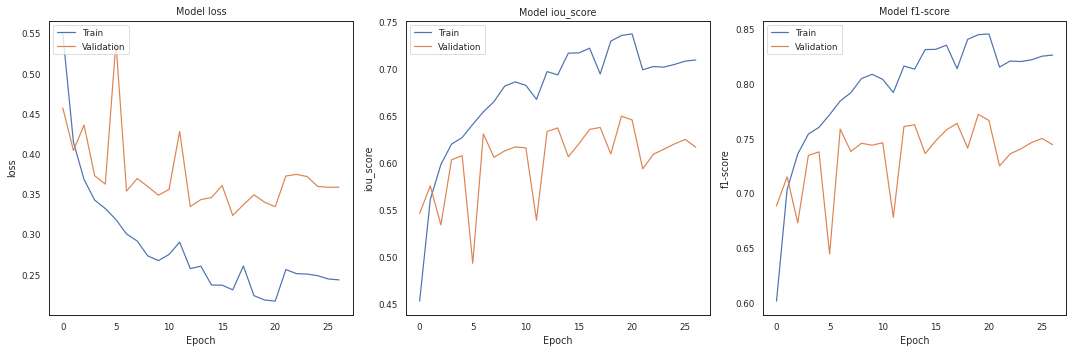

In [38]:
show_history_plot(history_8_2.history)

#### evaluation

In [ ]:
model_8_2.load_weights('/workspace/Model/trained_model/E8/E8_2_best_model.h5')

In [39]:
preprocess_input = sm.get_preprocessing('efficientnetb3')
test_datagenerator = SatelliteGenerator(
    FILE_PATH,
    TEST_SPLIT_IMG_PATH, 
    TEST_SPLIT_LABEL_PATH, 
    batch_size=BATCH_SIZE,
    augmentation=get_validation_augmentation(),
    preprocessing=get_preprocessing(preprocess_input),
    is_train=False
)
val_metrix = model_8_2.evaluate(valid_datagenerator)
test_metrix = model_8_2.evaluate(test_datagenerator)

75/75 [==============================] - 7s 99ms/step - loss: 0.3016 - iou_score: 0.6757 - f1-score: 0.7933


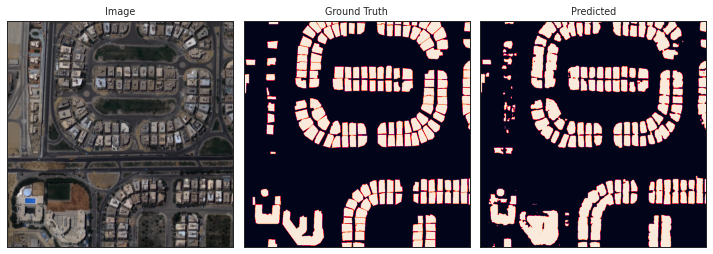

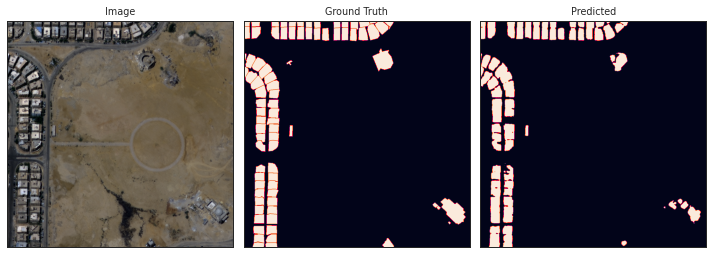

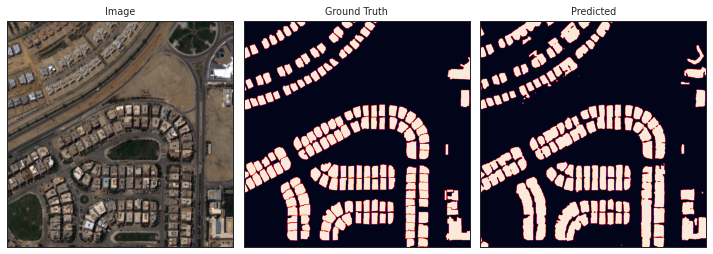

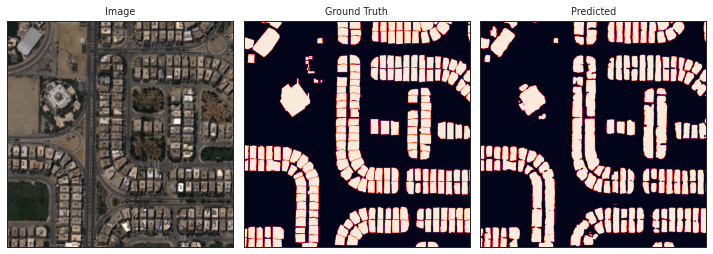

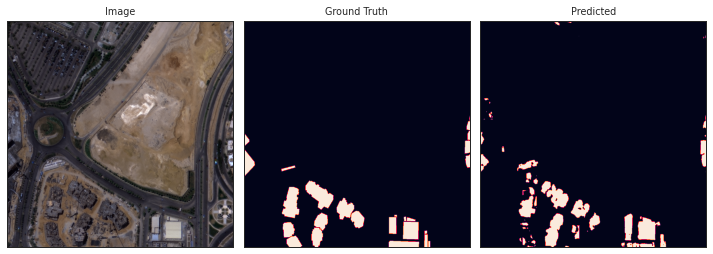

In [40]:
BACKBONE = 'efficientnetb3'
show_inference(model_8_2)

### E8-3

        keras.callbacks.ReduceLROnPlateau(monitor='val_loss', 
                                          factor=0.1, 
                                          patience=5, 
                                          verbose=1, 
                                          mode='min'),
       SPLIT_CNT = 15

In [49]:
lr = 1e-3
BATCH_SIZE = 32
EPOCHS=200
optim = keras.optimizers.Adam(learning_rate=lr)
train_datagenerator, valid_datagenerator = get_datagenerator(BATCH_SIZE=BATCH_SIZE)

In [48]:
def get_dice_loss(n_classes):
    dice_loss = sm.losses.DiceLoss()
    focal_loss = sm.losses.BinaryFocalLoss() if n_classes == 1 else sm.losses.CategoricalFocalLoss()
    total_loss = dice_loss + (1 * focal_loss)
    return total_loss

In [69]:
def get_model_8_3(model_name, optim, train, valid, MODEL_PATH, patience=5):
    BACKBONE = 'efficientnetb3'
    n_classes = 1
    activation = 'sigmoid'

    #create model
    tf.random.set_seed(2021)
    model = sm.Unet(BACKBONE, classes=n_classes, activation=activation, encoder_weights='imagenet')

    total_loss = get_dice_loss(n_classes)
    metrics = [sm.metrics.IOUScore(threshold=0.5), sm.metrics.FScore(threshold=0.5)]
    model.compile(optim, total_loss, metrics)
    
    log_dir = f"./logs/fit/{model_name}"
    tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)
    callbacks = [
        keras.callbacks.ModelCheckpoint(MODEL_PATH, save_weights_only=True, save_best_only=True, mode='min', monitor='val_loss'),
        keras.callbacks.ReduceLROnPlateau(monitor='val_loss', 
                                          factor=0.1, 
                                          patience=3, 
                                          verbose=1, 
                                          mode='min'),
        tensorboard_callback,
        keras.callbacks.EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=patience)
    ]
    
    return model, callbacks

In [51]:
model_8_3, callbacks = get_model_8_3(
    'E8-3',
    optim,
    train_datagenerator, 
    valid_datagenerator,
    '/workspace/Model/trained_model/E8/E8_3_best_model.h5',
    patience=10)

In [52]:
start_time = time.time()

history_8_3 = model_8_3.fit(
    train_datagenerator, 
    steps_per_epoch=len(train_datagenerator), 
    epochs=EPOCHS, 
    callbacks=callbacks, 
    validation_data=valid_datagenerator, 
    validation_steps=len(valid_datagenerator))

sec = time.time()-start_time
times = str(datetime.timedelta(seconds=sec)).split(".")
times = times[0]
print(f'WorkingTime : {times}')

Epoch 1/200
510/510 [==============================] - 247s 459ms/step - loss: 0.6314 - iou_score: 0.3805 - f1-score: 0.5197 - val_loss: 0.4907 - val_iou_score: 0.5291 - val_f1-score: 0.6741
Epoch 2/200
510/510 [==============================] - 231s 453ms/step - loss: 0.4369 - iou_score: 0.5402 - f1-score: 0.6864 - val_loss: 0.5384 - val_iou_score: 0.4915 - val_f1-score: 0.6268
Epoch 3/200
510/510 [==============================] - 230s 451ms/step - loss: 0.3718 - iou_score: 0.5990 - f1-score: 0.7371 - val_loss: 0.5870 - val_iou_score: 0.5224 - val_f1-score: 0.6696
Epoch 4/200
510/510 [==============================] - 231s 452ms/step - loss: 0.3613 - iou_score: 0.6041 - f1-score: 0.7405 - val_loss: 0.4590 - val_iou_score: 0.4994 - val_f1-score: 0.6474
Epoch 5/200
510/510 [==============================] - 230s 452ms/step - loss: 0.3317 - iou_score: 0.6240 - f1-score: 0.7576 - val_loss: 0.5281 - val_iou_score: 0.5228 - val_f1-score: 0.6691
Epoch 6/200
510/510 [========================

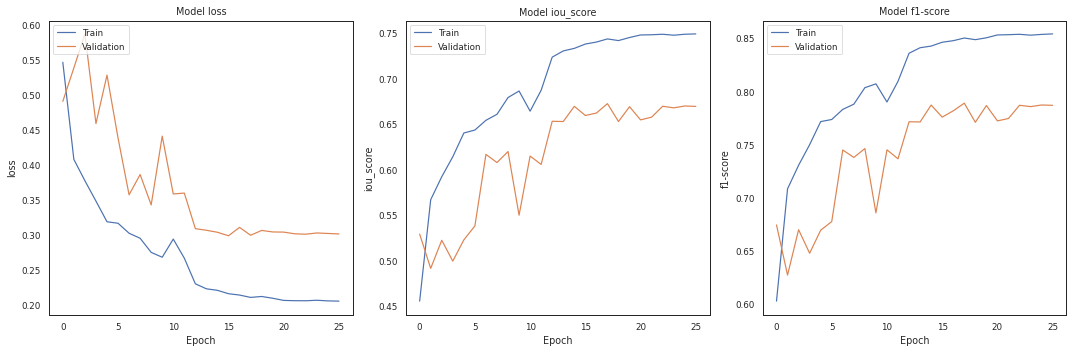

In [53]:
show_history_plot(history_8_3.history)

#### evaluation

In [ ]:
model_8_3.load_weights('/workspace/Model/trained_model/E8/E8_3_best_model.h5')

In [54]:
preprocess_input = sm.get_preprocessing('efficientnetb3')
test_datagenerator = SatelliteGenerator(
    FILE_PATH,
    TEST_SPLIT_IMG_PATH, 
    TEST_SPLIT_LABEL_PATH, 
    batch_size=BATCH_SIZE,
    augmentation=get_validation_augmentation(),
    preprocessing=get_preprocessing(preprocess_input),
    is_train=False
)
val_metrix = model_8_3.evaluate(valid_datagenerator)
test_metrix = model_8_3.evaluate(test_datagenerator)

75/75 [==============================] - 7s 97ms/step - loss: 0.2609 - iou_score: 0.7150 - f1-score: 0.8225


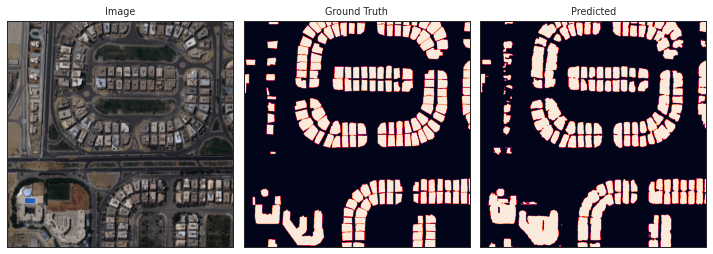

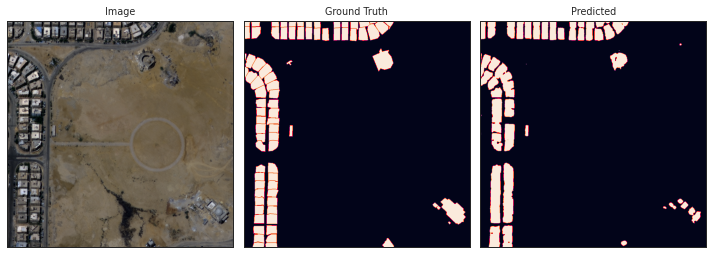

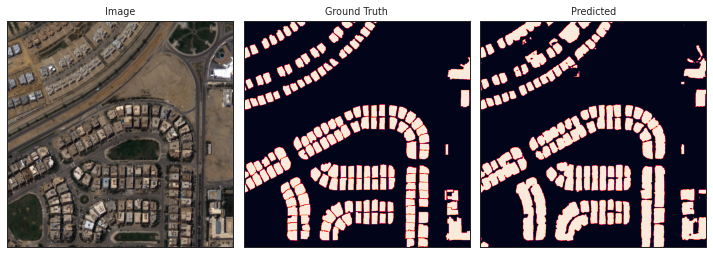

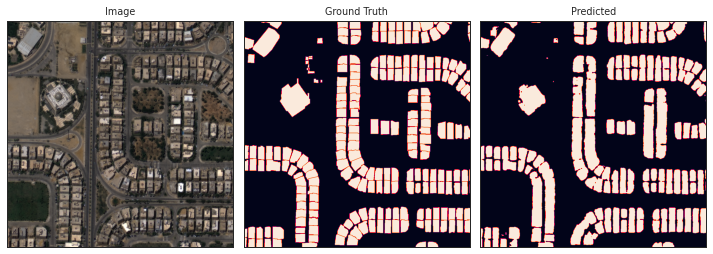

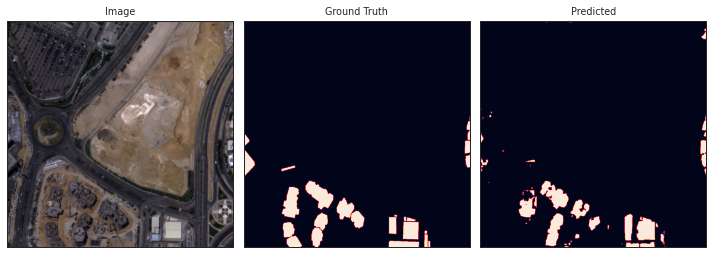

In [55]:
BACKBONE = 'efficientnetb3'
show_inference(model_8_3)

### E8-4

512x512x9(random crop)

In [57]:
CROP_NUM = 9
with h5py.File(FILE_PATH, "a") as f:
    train_size = f[TRAIN_IMG_PATH].shape[0] * CROP_NUM
    if 'split' in f[BASE_TARIN_DIR].keys(): del f[TRAIN_SPLIT_DIR]
    f[BASE_TARIN_DIR].create_group('split')
    f[BASE_TARIN_DIR]['split'].create_dataset('img', (train_size, 512, 512, 3), np.uint8)
    f[BASE_TARIN_DIR]['split'].create_dataset('label', (train_size, 512, 512), np.float32)

    val_size = f[VAL_IMG_PATH].shape[0] * CROP_NUM
    if 'split' in f[BASE_VAL_DIR].keys(): del f[VAL_SPLIT_DIR]
    f[BASE_VAL_DIR].create_group('split')
    f[BASE_VAL_DIR]['split'].create_dataset('img', (val_size, 512, 512, 3), np.uint8)
    f[BASE_VAL_DIR]['split'].create_dataset('label', (val_size, 512, 512), np.float32)

    test_size = f[TEST_IMG_PATH].shape[0] * CROP_NUM
    if 'split' in f[BASE_TEST_DIR].keys(): del f[TEST_SPLIT_DIR]
    f[BASE_TEST_DIR].create_group('split')
    f[BASE_TEST_DIR]['split'].create_dataset('img', (test_size, 512, 512, 3), np.uint8)
    f[BASE_TEST_DIR]['split'].create_dataset('label', (test_size, 512, 512), np.float32)

    sub_idx = 0
    for i in tqdm(range(f[TRAIN_IMG_PATH].shape[0])):
        img = f[TRAIN_IMG_PATH][i]
        mask = (f[TRAIN_LABEL_PATH][i] == COLOR_MAP[0])
        mask = (mask[:,:,0] +  mask[:,:,1] +  mask[:,:,2]).astype(np.float32)
        sub_imgs, sub_labels = random_crop(img, mask, CROP_NUM, height=512, width=512)
        
        sub_idx = save_png_imgs_labels(f[TRAIN_SPLIT_DIR], sub_idx, sub_imgs, sub_labels)

    sub_idx = 0
    for i in tqdm(range(f[VAL_IMG_PATH].shape[0])):
        img = f[VAL_IMG_PATH][i]
        mask = (f[VAL_LABEL_PATH][i] == COLOR_MAP[0])
        mask = (mask[:,:,0] +  mask[:,:,1] +  mask[:,:,2]).astype(np.float32)
        sub_imgs, sub_labels = random_crop(img, mask, CROP_NUM, height=512, width=512)

        sub_idx = save_png_imgs_labels(f[VAL_SPLIT_DIR], sub_idx, sub_imgs, sub_labels)
        
    sub_idx = 0
    for i in tqdm(range(f[TEST_IMG_PATH].shape[0])):
        img = f[TEST_IMG_PATH][i]
        mask = (f[TEST_LABEL_PATH][i] == COLOR_MAP[0])
        mask = (mask[:,:,0] +  mask[:,:,1] +  mask[:,:,2]).astype(np.float32)
        sub_imgs, sub_labels = random_crop(img, mask, CROP_NUM, height=512, width=512)

        sub_idx = save_png_imgs_labels(f[TEST_SPLIT_DIR], sub_idx, sub_imgs, sub_labels)

100%|██████████| 159/159 [00:12<00:00, 13.20it/s]


In [58]:
    lr = 1e-3
    BATCH_SIZE = 8
    EPOCHS=200
optim = keras.optimizers.Adam(learning_rate=lr)
train_datagenerator, valid_datagenerator = get_datagenerator(BATCH_SIZE=BATCH_SIZE)

In [62]:
model_8_4, callbacks = get_model_8_3(
    'E8-4',
    optim,
    train_datagenerator, 
    valid_datagenerator,
    '/workspace/Model/trained_model/E8/E8_4_best_model.h5',
    patience=10)

In [63]:
start_time = time.time()

history_8_4= model_8_4.fit(
    train_datagenerator, 
    steps_per_epoch=len(train_datagenerator), 
    epochs=EPOCHS, 
    callbacks=callbacks, 
    validation_data=valid_datagenerator, 
    validation_steps=len(valid_datagenerator))

sec = time.time()-start_time
times = str(datetime.timedelta(seconds=sec)).split(".")
times = times[0]
print(f'WorkingTime : {times}')

Epoch 1/200
1224/1224 [==============================] - 621s 496ms/step - loss: 0.6467 - iou_score: 0.3678 - f1-score: 0.5038 - val_loss: 0.5574 - val_iou_score: 0.4300 - val_f1-score: 0.5711
Epoch 2/200
1224/1224 [==============================] - 606s 495ms/step - loss: 0.4796 - iou_score: 0.5055 - f1-score: 0.6407 - val_loss: 0.4630 - val_iou_score: 0.5327 - val_f1-score: 0.6687
Epoch 3/200
1224/1224 [==============================] - 605s 494ms/step - loss: 0.4045 - iou_score: 0.5647 - f1-score: 0.6962 - val_loss: 0.4734 - val_iou_score: 0.5151 - val_f1-score: 0.6514
Epoch 4/200
1224/1224 [==============================] - 605s 494ms/step - loss: 0.3613 - iou_score: 0.5970 - f1-score: 0.7292 - val_loss: 0.4494 - val_iou_score: 0.5660 - val_f1-score: 0.6962
Epoch 5/200
1224/1224 [==============================] - 607s 496ms/step - loss: 0.3451 - iou_score: 0.6119 - f1-score: 0.7411 - val_loss: 0.5371 - val_iou_score: 0.4607 - val_f1-score: 0.5941
Epoch 6/200
1224/1224 [============

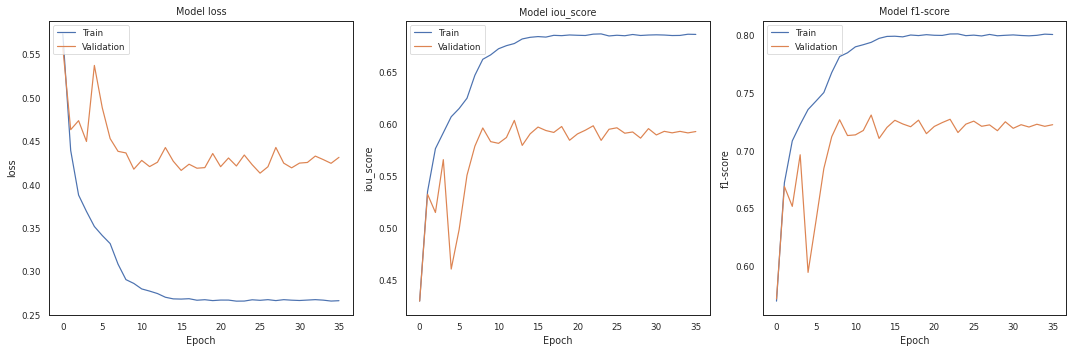

In [64]:
show_history_plot(history_8_4.history)

#### evaluation

In [65]:
model_8_4.load_weights('/workspace/Model/trained_model/E8/E8_4_best_model.h5')

In [66]:
preprocess_input = sm.get_preprocessing('efficientnetb3')
test_datagenerator = SatelliteGenerator(
    FILE_PATH,
    TEST_SPLIT_IMG_PATH, 
    TEST_SPLIT_LABEL_PATH, 
    batch_size=BATCH_SIZE,
    augmentation=get_validation_augmentation(),
    preprocessing=get_preprocessing(preprocess_input),
    is_train=False
)
val_metrix = model_8_4.evaluate(valid_datagenerator)
test_metrix = model_8_4.evaluate(test_datagenerator)

179/179 [==============================] - 57s 320ms/step - loss: 0.3617 - iou_score: 0.6212 - f1-score: 0.7415


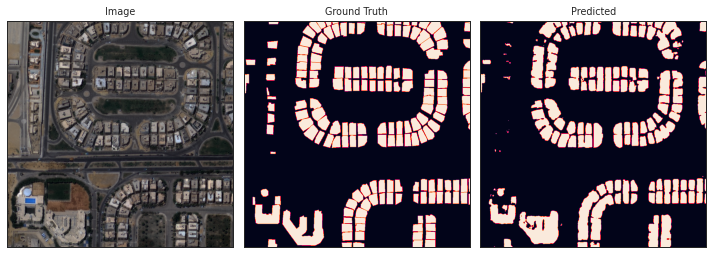

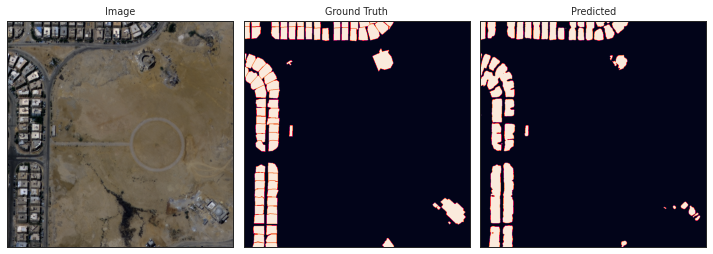

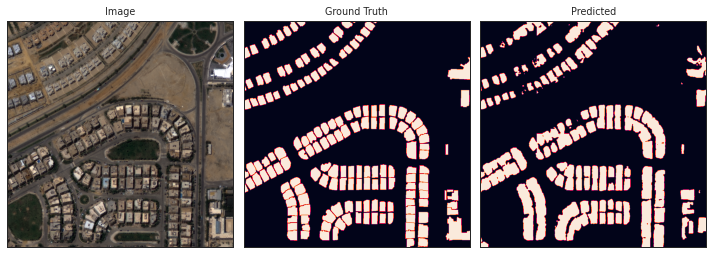

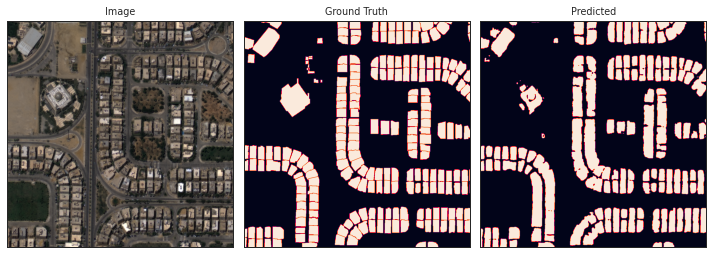

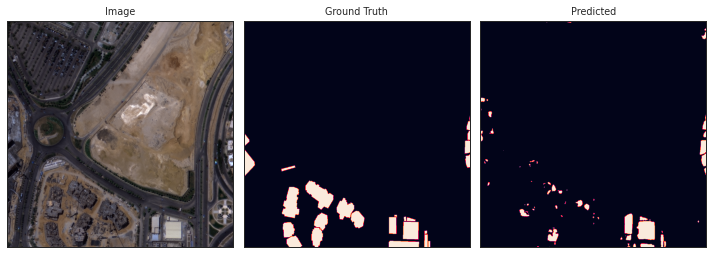

In [105]:
BACKBONE = 'efficientnetb3'
STRIDE_SIZE = 256
INPUT_SIZE = 512
SPLIT_CNT = 9
pts = get_slice_pos(SPLIT_CNT, STRIDE_SIZE, INPUT_SIZE)

show_inference(model_8_4)

### E8-5

128x128x100(random crop)

In [72]:
CROP_NUM = 100
IMG_WIDTH = IMG_HEIGHT = 128
with h5py.File(FILE_PATH, "a") as f:
    train_size = f[TRAIN_IMG_PATH].shape[0] * CROP_NUM
    if 'split' in f[BASE_TARIN_DIR].keys(): del f[TRAIN_SPLIT_DIR]
    f[BASE_TARIN_DIR].create_group('split')
    f[BASE_TARIN_DIR]['split'].create_dataset('img', (train_size, IMG_WIDTH, IMG_HEIGHT, 3), np.uint8)
    f[BASE_TARIN_DIR]['split'].create_dataset('label', (train_size, IMG_WIDTH, IMG_HEIGHT), np.float32)

    val_size = f[VAL_IMG_PATH].shape[0] * CROP_NUM
    if 'split' in f[BASE_VAL_DIR].keys(): del f[VAL_SPLIT_DIR]
    f[BASE_VAL_DIR].create_group('split')
    f[BASE_VAL_DIR]['split'].create_dataset('img', (val_size, IMG_WIDTH, IMG_HEIGHT,3), np.uint8)
    f[BASE_VAL_DIR]['split'].create_dataset('label', (val_size, IMG_WIDTH, IMG_HEIGHT), np.float32)

    test_size = f[TEST_IMG_PATH].shape[0] * CROP_NUM
    if 'split' in f[BASE_TEST_DIR].keys(): del f[TEST_SPLIT_DIR]
    f[BASE_TEST_DIR].create_group('split')
    f[BASE_TEST_DIR]['split'].create_dataset('img', (test_size, IMG_WIDTH, IMG_HEIGHT, 3), np.uint8)
    f[BASE_TEST_DIR]['split'].create_dataset('label', (test_size, IMG_WIDTH, IMG_HEIGHT), np.float32)

    sub_idx = 0
    for i in tqdm(range(f[TRAIN_IMG_PATH].shape[0])):
        img = f[TRAIN_IMG_PATH][i]
        mask = (f[TRAIN_LABEL_PATH][i] == COLOR_MAP[0])
        mask = (mask[:,:,0] +  mask[:,:,1] +  mask[:,:,2]).astype(np.float32)
        sub_imgs, sub_labels = random_crop(img, mask, CROP_NUM, height=IMG_HEIGHT, width=IMG_WIDTH)
        
        sub_idx = save_png_imgs_labels(f[TRAIN_SPLIT_DIR], sub_idx, sub_imgs, sub_labels)

    sub_idx = 0
    for i in tqdm(range(f[VAL_IMG_PATH].shape[0])):
        img = f[VAL_IMG_PATH][i]
        mask = (f[VAL_LABEL_PATH][i] == COLOR_MAP[0])
        mask = (mask[:,:,0] +  mask[:,:,1] +  mask[:,:,2]).astype(np.float32)
        sub_imgs, sub_labels = random_crop(img, mask, CROP_NUM, height=IMG_HEIGHT, width=IMG_WIDTH)

        sub_idx = save_png_imgs_labels(f[VAL_SPLIT_DIR], sub_idx, sub_imgs, sub_labels)
        
    sub_idx = 0
    for i in tqdm(range(f[TEST_IMG_PATH].shape[0])):
        img = f[TEST_IMG_PATH][i]
        mask = (f[TEST_LABEL_PATH][i] == COLOR_MAP[0])
        mask = (mask[:,:,0] +  mask[:,:,1] +  mask[:,:,2]).astype(np.float32)
        sub_imgs, sub_labels = random_crop(img, mask, CROP_NUM, height=IMG_HEIGHT, width=IMG_WIDTH)

        sub_idx = save_png_imgs_labels(f[TEST_SPLIT_DIR], sub_idx, sub_imgs, sub_labels)

100%|██████████| 159/159 [00:13<00:00, 12.07it/s]


In [88]:
lr = 1e-3
BATCH_SIZE = 128
EPOCHS=200
optim = keras.optimizers.Adam(learning_rate=lr)
train_datagenerator, valid_datagenerator = get_datagenerator(BATCH_SIZE=BATCH_SIZE)

In [89]:
model_8_5, callbacks = get_model_8_3(
    'E8-5',
    optim,
    train_datagenerator, 
    valid_datagenerator,
    '/workspace/Model/trained_model/E8/E8_5_best_model.h5',
    patience=10)

In [90]:
start_time = time.time()

history_8_5= model_8_5.fit(
    train_datagenerator, 
    steps_per_epoch=len(train_datagenerator), 
    epochs=EPOCHS, 
    callbacks=callbacks, 
    validation_data=valid_datagenerator, 
    validation_steps=len(valid_datagenerator))

sec = time.time()-start_time
times = str(datetime.timedelta(seconds=sec)).split(".")
times = times[0]
print(f'WorkingTime : {times}')

Epoch 1/200
850/850 [==============================] - 423s 480ms/step - loss: 0.6152 - iou_score: 0.3960 - f1-score: 0.5419 - val_loss: 0.5330 - val_iou_score: 0.4718 - val_f1-score: 0.6108
Epoch 2/200
850/850 [==============================] - 349s 410ms/step - loss: 0.4097 - iou_score: 0.5585 - f1-score: 0.7029 - val_loss: 0.4712 - val_iou_score: 0.5477 - val_f1-score: 0.6900
Epoch 3/200
850/850 [==============================] - 350s 412ms/step - loss: 0.3646 - iou_score: 0.5965 - f1-score: 0.7355 - val_loss: 0.4430 - val_iou_score: 0.5227 - val_f1-score: 0.6713
Epoch 4/200
850/850 [==============================] - 351s 412ms/step - loss: 0.3600 - iou_score: 0.5948 - f1-score: 0.7339 - val_loss: 0.3972 - val_iou_score: 0.5839 - val_f1-score: 0.7218
Epoch 5/200
850/850 [==============================] - 348s 410ms/step - loss: 0.3309 - iou_score: 0.6191 - f1-score: 0.7555 - val_loss: 0.3881 - val_iou_score: 0.5920 - val_f1-score: 0.7275
Epoch 6/200
850/850 [========================

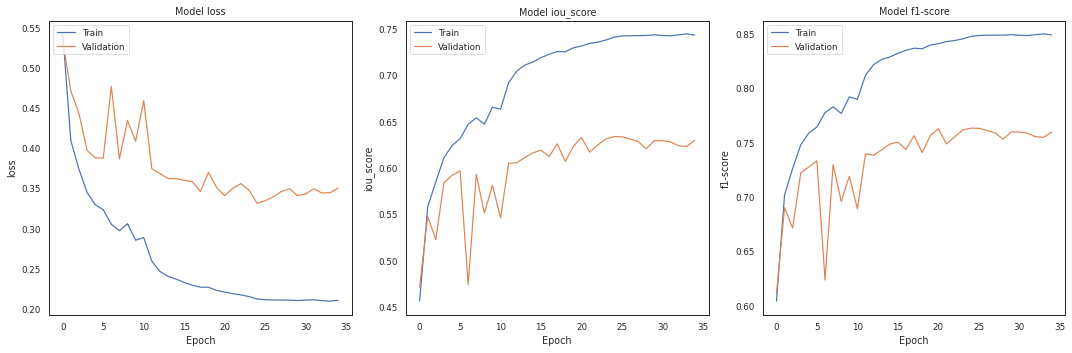

In [91]:
show_history_plot(history_8_5.history)

#### evaluation

In [93]:
model_8_5.load_weights('/workspace/Model/trained_model/E8/E8_5_best_model.h5')

In [94]:
preprocess_input = sm.get_preprocessing('efficientnetb3')
test_datagenerator = SatelliteGenerator(
    FILE_PATH,
    TEST_SPLIT_IMG_PATH, 
    TEST_SPLIT_LABEL_PATH, 
    batch_size=BATCH_SIZE,
    augmentation=get_validation_augmentation(),
    preprocessing=get_preprocessing(preprocess_input),
    is_train=False
)
val_metrix = model_8_5.evaluate(valid_datagenerator)
test_metrix = model_8_5.evaluate(test_datagenerator)

125/125 [==============================] - 64s 513ms/step - loss: 0.2888 - iou_score: 0.6791 - f1-score: 0.7972


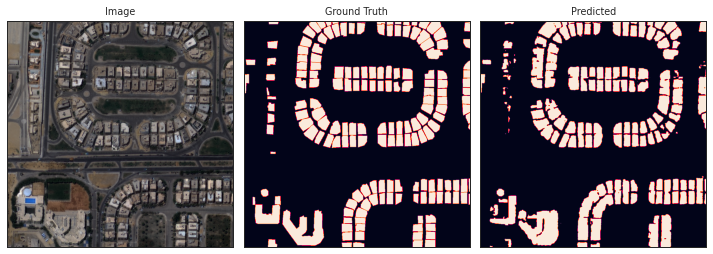

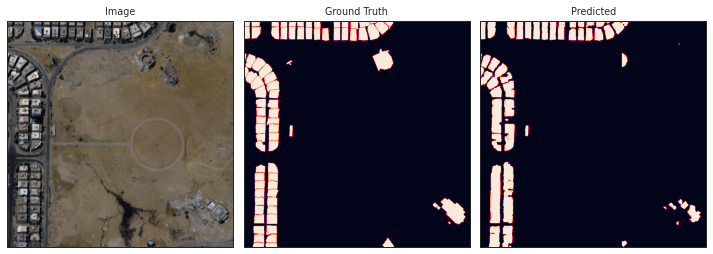

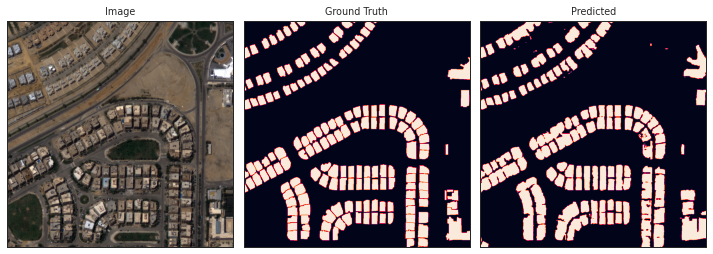

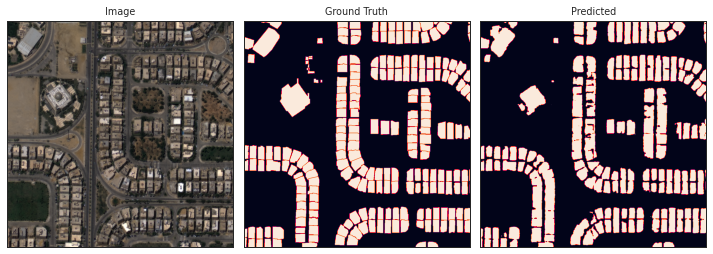

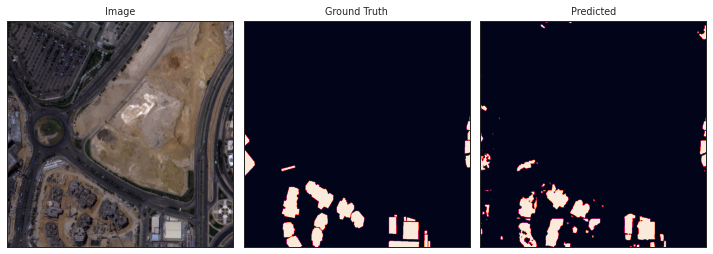

In [104]:
BACKBONE = 'efficientnetb3'
STRIDE_SIZE = 128
INPUT_SIZE = 128
SPLIT_CNT = 64
pts = get_slice_pos(SPLIT_CNT, STRIDE_SIZE, INPUT_SIZE)

show_inference(model_8_5)

## additional information
---

### 1. learning rate
- ref : https://github.com/peteryuX/pcdarts-tf2/blob/4ecf2224cd414586d988c2d3d4316af0d518e8e8/modules/lr_scheduler.py
- ref : https://velog.io/@changdaeoh/learningrateschedule

In [35]:
import tensorflow as tf
import matplotlib as mpl
from matplotlib import pyplot as plt
import matplotlib.ticker as mtick
mpl.style.use('default')
import seaborn
seaborn.set(style='whitegrid')
seaborn.set_context('paper')

def MultiStepLR(initial_learning_rate, lr_steps, lr_rate, name='MultiStepLR'):
    """Multi-steps learning rate scheduler."""
    lr_steps_value = [initial_learning_rate]
    for _ in range(len(lr_steps)):
        lr_steps_value.append(lr_steps_value[-1] * lr_rate)
    return tf.keras.optimizers.schedules.PiecewiseConstantDecay(
        boundaries=lr_steps, values=lr_steps_value)


def CosineAnnealingLR_Restart(initial_learning_rate, t_period, lr_min=0.):
    """Cosine annealing learning rate scheduler with restart."""
    return tf.keras.experimental.CosineDecayRestarts(
        initial_learning_rate=initial_learning_rate,
        first_decay_steps=t_period, t_mul=1.0, m_mul=1.0,
        alpha=lr_min / initial_learning_rate)


def CosineAnnealingLR(initial_learning_rate, t_period, lr_min=0.):
    """Cosine annealing learning rate scheduler with restart."""
    return tf.keras.experimental.CosineDecay(
        initial_learning_rate=initial_learning_rate,
        decay_steps=t_period, alpha=lr_min / initial_learning_rate)


def show_learning_rate(lr_scheduler, title="Title"):
    N_iter = 10000
    step_list = list(range(0, N_iter, 10))
    lr_list = []
    for i in step_list:
        current_lr = lr_scheduler(i).numpy()
        lr_list.append(current_lr)

    plt.figure(1)
    plt.subplot(111)
    plt.ticklabel_format(style='sci', axis='x', scilimits=(0, 0))
    plt.title(title, fontsize=16, color='k')
    plt.plot(step_list, lr_list, linewidth=1.5, label='learning rate scheme')
    legend = plt.legend(loc='upper right', shadow=False)
    ax = plt.gca()
    labels = ax.get_xticks().tolist()
    for k, v in enumerate(labels):
        labels[k] = str(int(v / 1000)) + 'K'
    ax.set_xticklabels(labels)
    ax.yaxis.set_major_formatter(mtick.FormatStrFormatter('%.1e'))

    ax.set_ylabel('Learning rate')
    ax.set_xlabel('Iteration')
    fig = plt.gcf()
    plt.show()

/home/aiffel-dj1/anaconda3/envs/aiffel/lib/python3.7/site-packages/ipykernel_launcher.py:52: UserWarning: FixedFormatter should only be used together with FixedLocator


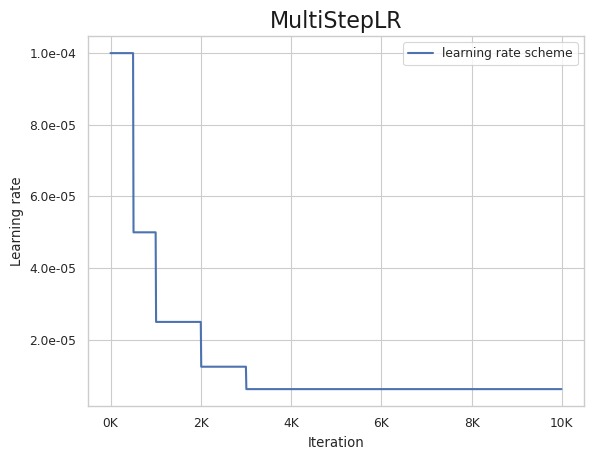

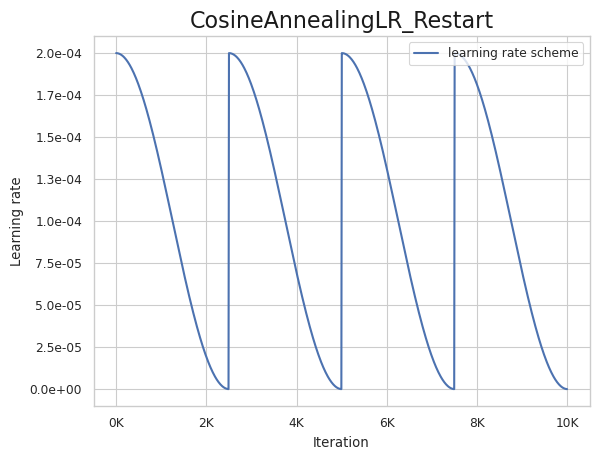

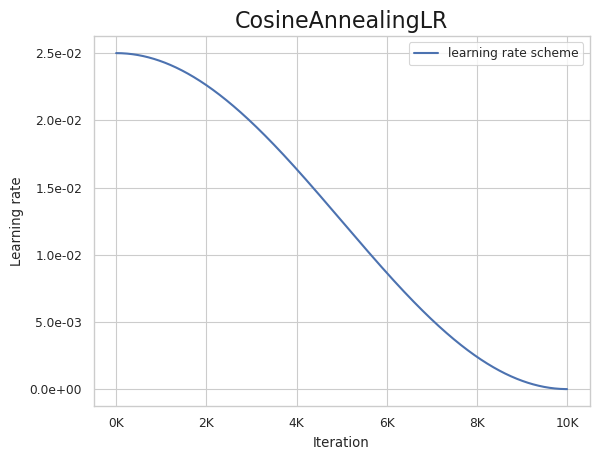

In [36]:
show_learning_rate(MultiStepLR(1e-4, [500, 1000, 2000, 3000], 0.5), 'MultiStepLR')
show_learning_rate(CosineAnnealingLR_Restart(2e-4, 2500, 1e-7), 'CosineAnnealingLR_Restart')
show_learning_rate(CosineAnnealingLR(0.025, 10000, 0), 'CosineAnnealingLR')